In [1]:
#This notebook is best run in Google Colab
import pandas as pd
import requests
import matplotlib.pyplot as plt

In [2]:
# Run this if running from Google Drive
#Mounting Google Drive to Open and Save files
from google.colab import drive
drive.mount('/drive')

ModuleNotFoundError: No module named 'google'

[Contains information from [Resale Flat Prices] accessed on [30th September 2021] from [https://data.gov.sg/dataset/resale-flat-prices] which is made available under the terms of the Singapore Open Data Licence version 1.0 [https://data.gov.sg/open-data-licence]]


In [3]:
#Using requests library to get data from data.gov.sg
#Visit the following for API details: https://data.gov.sg/dataset/ckan-datastore-search?resource_id=6a7db56a-4df7-4228-8d57-37ded1b09306
#Searching for data in years 2021
dataset_id = 'f1765b54-a209-4718-8d38-a39237f502b3'
result_limit = '999999' #tweak the limit to your liking
filter = '{"month":"2021"}' #the filter needs to be in dictionary form
req = requests.get('https://data.gov.sg/api/action/datastore_search?resource_id='+dataset_id+'&limit='+result_limit+'&q='+filter, headers={'User-Agent': 'Mozilla/5.0'})
data_json = req.json()

In [4]:
#displaying the last record retrieved in JSON format
data_json['result']['records'][len(data_json['result']['records'])-1]

{'town': 'YISHUN',
 'flat_type': 'EXECUTIVE',
 '_full_count': '27137',
 'flat_model': 'Apartment',
 'floor_area_sqm': '142',
 'street_name': 'YISHUN ST 81',
 'resale_price': '738000',
 'rank month': 0.0573088,
 'month': '2021-12',
 'remaining_lease': '65 years 01 month',
 'lease_commence_date': '1987',
 'storey_range': '01 TO 03',
 '_id': 112727,
 'block': '877'}

In [5]:
#converting JSON data into a Pandas data frame
df_final = pd.DataFrame(data_json['result']['records'])
print(df_final.head())
print(len(df_final))

         town flat_type _full_count      flat_model floor_area_sqm  \
0  ANG MO KIO    2 ROOM       27137        Improved             45   
1  ANG MO KIO    2 ROOM       27137        Improved             45   
2  ANG MO KIO    3 ROOM       27137  New Generation             73   
3  ANG MO KIO    3 ROOM       27137  New Generation             67   
4  ANG MO KIO    3 ROOM       27137  New Generation             67   

        street_name resale_price  rank month    month     remaining_lease  \
0  ANG MO KIO AVE 4       225000    0.057309  2021-01   64 years 01 month   
1  ANG MO KIO AVE 4       211000    0.057309  2021-01   64 years 01 month   
2  ANG MO KIO AVE 1       275888    0.057309  2021-01  54 years 04 months   
3  ANG MO KIO AVE 1       316800    0.057309  2021-01   56 years 01 month   
4  ANG MO KIO AVE 1       305000    0.057309  2021-01            56 years   

  lease_commence_date storey_range    _id block  
0                1986     07 TO 09  85591   170  
1               

In [6]:
# Data cleaning
#Removing periods in the address strings that cause the onemap API to not return correct results
df_final['street_name'] = df_final['street_name'].str.replace(".","", n=-1)

C:\Users\SHENGJ~1\AppData\Local\Temp/ipykernel_6336/497359614.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_final['street_name'] = df_final['street_name'].str.replace(".","", n=-1)


In [7]:
#All values should return -1 to indicate strings like "ST. GEORGE'S LANE" are not found
df_final['street_name'].str.find("ST. GEORGE'S").describe()

count    27137.0
mean        -1.0
std          0.0
min         -1.0
25%         -1.0
50%         -1.0
75%         -1.0
max         -1.0
Name: street_name, dtype: float64

In [8]:
# Creating a new dataframe column 'address' from 'block' and 'street_name' columns
df_final['address'] = df_final['block'] + ' ' + df_final['street_name']

In [9]:
df_final.head()

town flat_type _full_count      flat_model floor_area_sqm  \
0  ANG MO KIO    2 ROOM       27137        Improved             45   
1  ANG MO KIO    2 ROOM       27137        Improved             45   
2  ANG MO KIO    3 ROOM       27137  New Generation             73   
3  ANG MO KIO    3 ROOM       27137  New Generation             67   
4  ANG MO KIO    3 ROOM       27137  New Generation             67   

        street_name resale_price  rank month    month     remaining_lease  \
0  ANG MO KIO AVE 4       225000    0.057309  2021-01   64 years 01 month   
1  ANG MO KIO AVE 4       211000    0.057309  2021-01   64 years 01 month   
2  ANG MO KIO AVE 1       275888    0.057309  2021-01  54 years 04 months   
3  ANG MO KIO AVE 1       316800    0.057309  2021-01   56 years 01 month   
4  ANG MO KIO AVE 1       305000    0.057309  2021-01            56 years   

  lease_commence_date storey_range    _id block               address  
0                1986     07 TO 09  85591   170  170 ANG MO KIO AVE 4  
1                1986     01 TO 03  85592   170  170 ANG MO KIO AVE 4  
2                1976     04 TO 06  85593   216  216 ANG MO KIO AVE 1  
3                1978     07 TO 09  85594   223  223 ANG MO KIO AVE 1  
4                1978     10 TO 12  85595   223  223 ANG MO KIO AVE 1

In [10]:
# Removing unnecessary columns
df_final = df_final.drop(['rank month','_full_count'], axis=1)

[Contains information from [Planning Area Polygons, Reverse Geocode] accessed on [5 October 2021] from [https://www.onemap.gov.sg/docs/#planning-area] which is made available under the terms of the Singapore Open Data Licence version 1.0 [https://www.onemap.gov.sg/legal/opendatalicence.html]]

In [11]:
# Getting latitude and longitude data from the onemap API. 
# Code referenced from here: https://towardsdatascience.com/geocoding-singapore-coordinates-onemap-api-3e1542bf26f7
def getcoordinates(address):
    req = requests.get('https://developers.onemap.sg/commonapi/search?searchVal='+address+'&returnGeom=Y&getAddrDetails=Y&pageNum=1', headers={'User-Agent': 'Mozilla/5.0'})
    resultsdict = eval(req.text)
    if len(resultsdict['results'])>0:
        return resultsdict['results'][0]['LATITUDE'], resultsdict['results'][0]['LONGITUDE']
    else:
        pass

In [12]:
# This code block takes a very long time to run. 
coordinateslist= []
count = 0
failed_count = 0
for address in df_final['address']:
    try:
        if len(getcoordinates(address))>0:
            count = count + 1
            print('Extracting',count,'out of',len(df_final['address']),'addresses',address,getcoordinates(address))
            coordinateslist.append(getcoordinates(address))
    except:
        count = count + 1           
        failed_count = failed_count + 1
        print('Failed to extract',count,'out of',len(df_final['address']),'addresses',address)
        coordinateslist.append(None)
print('Total Number of Addresses With No Coordinates',failed_count)

Extracting 1 out of 27137 addresses 170 ANG MO KIO AVE 4 ('1.37400071781295', '103.83643153142')
Extracting 2 out of 27137 addresses 170 ANG MO KIO AVE 4 ('1.37400071781295', '103.83643153142')
Extracting 3 out of 27137 addresses 216 ANG MO KIO AVE 1 ('1.36619678831054', '103.841505011903')
Extracting 4 out of 27137 addresses 223 ANG MO KIO AVE 1 ('1.36604808445916', '103.838122716883')
Extracting 5 out of 27137 addresses 223 ANG MO KIO AVE 1 ('1.36604808445916', '103.838122716883')
Extracting 6 out of 27137 addresses 331 ANG MO KIO AVE 1 ('1.36211140145298', '103.85076647513')
Extracting 7 out of 27137 addresses 130 ANG MO KIO AVE 3 ('1.37039791675237', '103.841878840032')
Extracting 8 out of 27137 addresses 321 ANG MO KIO AVE 1 ('1.36514126911853', '103.8487041858')
Extracting 9 out of 27137 addresses 319 ANG MO KIO AVE 1 ('1.36511023350774', '103.847379037914')
Extracting 10 out of 27137 addresses 456 ANG MO KIO AVE 10 ('1.36716071992678', '103.858658520644')
Extracting 11 out of 27

In [13]:
#combining the resale flat data frame with the cooridinates data frame
df_coordinates = pd.DataFrame(coordinateslist)
df_combined = df_final.join(df_coordinates)
df_combined = df_combined.rename(columns={0:'Latitude', 1:'Longitude'})

In [14]:
df_combined

town  flat_type      flat_model floor_area_sqm       street_name  \
0      ANG MO KIO     2 ROOM        Improved             45  ANG MO KIO AVE 4   
1      ANG MO KIO     2 ROOM        Improved             45  ANG MO KIO AVE 4   
2      ANG MO KIO     3 ROOM  New Generation             73  ANG MO KIO AVE 1   
3      ANG MO KIO     3 ROOM  New Generation             67  ANG MO KIO AVE 1   
4      ANG MO KIO     3 ROOM  New Generation             67  ANG MO KIO AVE 1   
...           ...        ...             ...            ...               ...   
27132      YISHUN     5 ROOM            DBSS            112     YISHUN AVE 11   
27133      YISHUN     5 ROOM        Improved            121      YISHUN ST 21   
27134      YISHUN     5 ROOM        Improved            127      YISHUN ST 81   
27135      YISHUN  EXECUTIVE      Maisonette            154     YISHUN AVE 11   
27136      YISHUN  EXECUTIVE       Apartment            142      YISHUN ST 81   

      resale_price    month     remaining_lease lease_commence_date  \
0           225000  2021-01   64 years 01 month                1986   
1           211000  2021-01   64 years 01 month                1986   
2           275888  2021-01  54 years 04 months                1976   
3           316800  2021-01   56 years 01 month                1978   
4           305000  2021-01            56 years                1978   
...            ...      ...                 ...                 ...   
27132       848000  2021-12  90 years 11 months                2013   
27133       500000  2021-12  62 years 07 months                1985   
27134       658000  2021-12  64 years 11 months                1987   
27135       651000  2021-12  65 years 08 months                1988   
27136       738000  2021-12   65 years 01 month                1987   

      storey_range     _id block               address          Latitude  \
0         07 TO 09   85591   170  170 ANG MO KIO AVE 4  1.37400071781295   
1         01 TO 03   85592   170  170 ANG MO KIO AVE 4  1.37400071781295   
2         04 TO 06   85593   216  216 ANG MO KIO AVE 1  1.36619678831054   
3         07 TO 09   85594   223  223 ANG MO KIO AVE 1  1.36604808445916   
4         10 TO 12   85595   223  223 ANG MO KIO AVE 1  1.36604808445916   
...            ...     ...   ...                   ...               ...   
27132     10 TO 12  112723  348A    348A YISHUN AVE 11  1.42735307116966   
27133     01 TO 03  112724   221      221 YISHUN ST 21  1.43371773752649   
27134     10 TO 12  112725   838      838 YISHUN ST 81  1.41642178701227   
27135     01 TO 03  112726   344     344 YISHUN AVE 11   1.4290305000563   
27136     01 TO 03  112727   877      877 YISHUN ST 81  1.41390219124124   

              Longitude  
0       103.83643153142  
1       103.83643153142  
2      103.841505011903  
3      103.838122716883  
4      103.838122716883  
...                 ...  
27132  103.841219186625  
27133  103.836051519498  
27134  103.833559766776  
27135   103.84430354208  
27136  103.835453933174  

[27137 rows x 15 columns]

In [15]:
#Saving the data frame to Google Drive (Optional)
#df_combined.to_csv('/drive/My Drive/Python Practice/HDB Resale Details 2021.csv')
df_combined.to_csv('HDB Resale Details 2021.csv')

In [2]:
#Loading the data frame from Google Drive (Optional)
#df_combined = pd.read_csv('/drive/My Drive/Python Practice/HDB Resale Details 2021.csv')
df_combined = pd.read_csv('HDB Resale Details 2021.csv')

In [3]:
#installing and importing libraries to process MRT shape file
#!pip install geopandas
#import geopandas
import matplotlib.pyplot as plt
from geopy import distance
%matplotlib inline

[Contains information from [Train Station] Dataset accessed on [30th September 2021] from [https://datamall.lta.gov.sg/content/datamall/en/search_datasets.html?searchText=mrt] which is made available under the terms of the Singapore Open Data Licence version 1.0 [https://datamall.lta.gov.sg/content/datamall/en/SingaporeOpenDataLicence.html]]

In [ ]:
#MRT information downloaded from https://datamall.lta.gov.sg/content/dam/datamall/datasets/Geospatial/TrainStation.zip and placed in Google Drive
#opening and loading the shapefile using geopandas library

zipfile = "/drive/My Drive/Python Practice/TrainStation.zip!TrainStation_Aug2021/MRTLRTStnPtt.shp"
gdf_mrt = geopandas.read_file(zipfile)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
#Checking the Coordinate Reference System(CRS). Singapore uses the "SVY21" cartesian(flat earth) projection . See https://epsg.io/3414
gdf_mrt.crs

<Projected CRS: PROJCS["SVY21",GEOGCS["SVY21[WGS84]",DATUM["WGS_19 ...>
Name: SVY21
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
gdf_mrt.head()

OBJECTID                    STN_NAME STN_NO                     geometry
0         1           EUNOS MRT STATION    EW7  POINT (35782.955 33560.078)
1         2  CHINESE GARDEN MRT STATION   EW25  POINT (16790.747 36056.302)
2         3          KHATIB MRT STATION   NS14  POINT (27962.311 44352.568)
3         4          KRANJI MRT STATION    NS7  POINT (20081.697 45214.548)
4         5         REDHILL MRT STATION   EW18  POINT (26163.478 30218.820)

In [ ]:
#Converting currect CRS to EPSG.4326 (elipsoid projection) i.e. GPS Coordinate System to obtain coordinates in decimal degrees. See https://epsg.io/4326
gdf_mrt = gdf_mrt.to_crs("EPSG:4326")

In [4]:
gdf_mrt = pd.read_csv('MRT Stations.csv', index_col=0)

In [5]:
#Coordinates are now in GPS format but the latitude and longitude are reversed.
gdf_mrt.head()

OBJECTID                    STN_NAME STN_NO  \
0         1           EUNOS MRT STATION    EW7   
1         2  CHINESE GARDEN MRT STATION   EW25   
2         3          KHATIB MRT STATION   NS14   
3         4          KRANJI MRT STATION    NS7   
4         5         REDHILL MRT STATION   EW18   

                                      geometry  Latitude   Longitude  
0  POINT (103.9032524667383 1.319778951553637)  1.319779  103.903252  
1  POINT (103.7325967380734 1.342352820874744)  1.342353  103.732597  
2  POINT (103.8329799077383 1.417383370153547)  1.417383  103.832980  
3  POINT (103.7621654109002 1.425177698770448)  1.425178  103.762165  
4   POINT (103.816816670149 1.289562726402453)  1.289563  103.816817

In [ ]:
#extracting coordinates into seperate columns
gdf_mrt['Latitude'] = gdf_mrt.geometry.apply(lambda p: p.y)
gdf_mrt['Longitude'] = gdf_mrt.geometry.apply(lambda p: p.x)

In [12]:
gdf_mrt.drop('OBJECTID', axis=1, inplace=True)
gdf_mrt.head()

STN_NAME STN_NO  \
0           EUNOS MRT STATION    EW7   
1  CHINESE GARDEN MRT STATION   EW25   
2          KHATIB MRT STATION   NS14   
3          KRANJI MRT STATION    NS7   
4         REDHILL MRT STATION   EW18   

                                      geometry  Latitude   Longitude  
0  POINT (103.9032524667383 1.319778951553637)  1.319779  103.903252  
1  POINT (103.7325967380734 1.342352820874744)  1.342353  103.732597  
2  POINT (103.8329799077383 1.417383370153547)  1.417383  103.832980  
3  POINT (103.7621654109002 1.425177698770448)  1.425178  103.762165  
4   POINT (103.816816670149 1.289562726402453)  1.289563  103.816817

<AxesSubplot:>

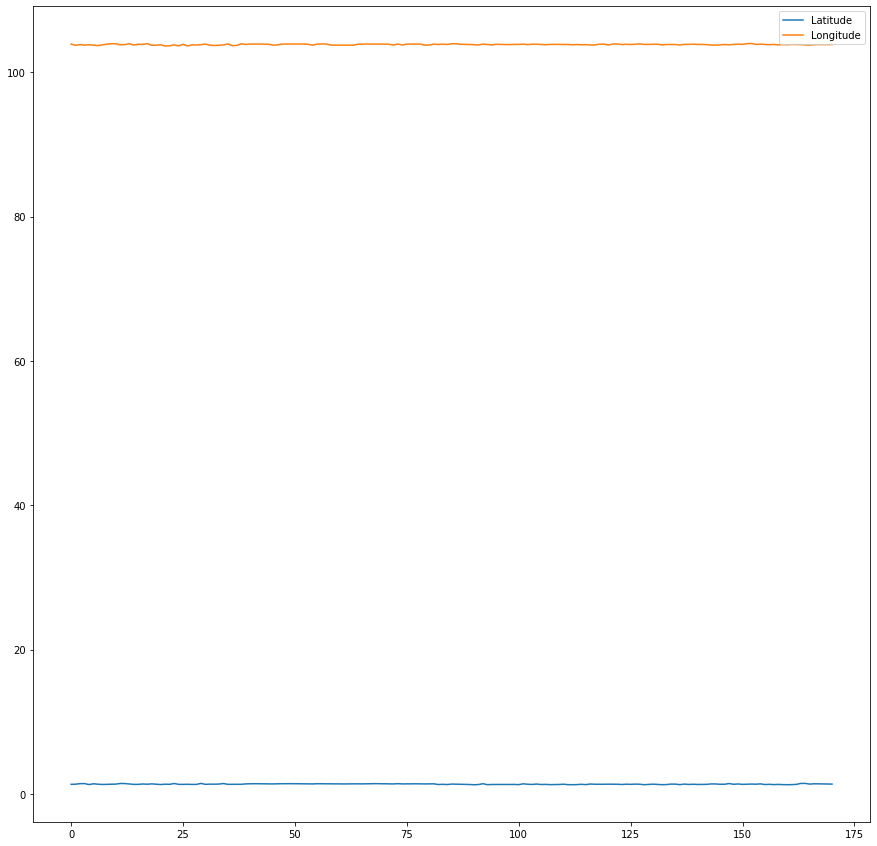

In [13]:
#Plotting MRT&LRT station locations
fig,ax = plt.subplots(figsize = (15,15))
gdf_mrt.plot(ax=ax)

In [ ]:
#Saving to Google Drive
gdf_mrt.to_csv('/drive/My Drive/Python Practice/MRT Stations.csv')

In [7]:
#Creating lists of the closest station and the corresponding distance for each address
distance_list = []
closest_station_list = []

for row in range(0, len(df_combined)):
  shortest_distance = 0
  closest_station = ''
  pnt_flat= (df_combined['Latitude'][row], df_combined['Longitude'][row])
  
  for stn in range(0, len(gdf_mrt)):
    pnt_stn = (gdf_mrt['Latitude'][stn],gdf_mrt['Longitude'][stn])
    dist = distance.distance(pnt_flat, pnt_stn).m
        
    if shortest_distance == 0:
      shortest_distance = dist
      closest_station = gdf_mrt['STN_NAME'][stn]
    elif dist < shortest_distance:
      shortest_distance = dist
      closest_station = gdf_mrt['STN_NAME'][stn]
    else:
      pass
    #print(row, stn, dist, shortest_distance, closest_station)
  
  print("Record:{} {} is {:.0f}m away from closest station, {}".format(row, df_combined['address'][row],shortest_distance, closest_station))
  
  distance_list.append(shortest_distance)
  closest_station_list.append(closest_station)

Record:0 170 ANG MO KIO AVE 4 is 216m away from closest station, MAYFLOWER MRT STATION
Record:1 170 ANG MO KIO AVE 4 is 216m away from closest station, MAYFLOWER MRT STATION
Record:2 216 ANG MO KIO AVE 1 is 834m away from closest station, MAYFLOWER MRT STATION
Record:3 223 ANG MO KIO AVE 1 is 652m away from closest station, BRIGHT HILL MRT STATION
Record:4 223 ANG MO KIO AVE 1 is 652m away from closest station, BRIGHT HILL MRT STATION
Record:5 331 ANG MO KIO AVE 1 is 805m away from closest station, ANG MO KIO MRT STATION
Record:6 130 ANG MO KIO AVE 3 is 593m away from closest station, MAYFLOWER MRT STATION
Record:7 321 ANG MO KIO AVE 1 is 485m away from closest station, ANG MO KIO MRT STATION
Record:8 319 ANG MO KIO AVE 1 is 548m away from closest station, ANG MO KIO MRT STATION
Record:9 456 ANG MO KIO AVE 10 is 1001m away from closest station, ANG MO KIO MRT STATION
Record:10 561 ANG MO KIO AVE 10 is 892m away from closest station, ANG MO KIO MRT STATION
Record:11 463 ANG MO KIO AVE 1

In [8]:
#Converting lists to data frames
df_closest_station = pd.DataFrame(closest_station_list, columns=['Nearest Station'])
df_distance = pd.DataFrame(distance_list, columns=['Station Distance'])

In [9]:
#Merging nearest station and station distance data frames with the resale flat dataframe
df_complete = df_combined.join([df_closest_station, df_distance])

In [10]:
df_complete.head()

Unnamed: 0        town flat_type      flat_model  floor_area_sqm  \
0           0  ANG MO KIO    2 ROOM        Improved            45.0   
1           1  ANG MO KIO    2 ROOM        Improved            45.0   
2           2  ANG MO KIO    3 ROOM  New Generation            73.0   
3           3  ANG MO KIO    3 ROOM  New Generation            67.0   
4           4  ANG MO KIO    3 ROOM  New Generation            67.0   

        street_name  resale_price    month     remaining_lease  \
0  ANG MO KIO AVE 4      225000.0  2021-01   64 years 01 month   
1  ANG MO KIO AVE 4      211000.0  2021-01   64 years 01 month   
2  ANG MO KIO AVE 1      275888.0  2021-01  54 years 04 months   
3  ANG MO KIO AVE 1      316800.0  2021-01   56 years 01 month   
4  ANG MO KIO AVE 1      305000.0  2021-01            56 years   

   lease_commence_date storey_range    _id block               address  \
0                 1986     07 TO 09  85591   170  170 ANG MO KIO AVE 4   
1                 1986     01 TO 03  85592   170  170 ANG MO KIO AVE 4   
2                 1976     04 TO 06  85593   216  216 ANG MO KIO AVE 1   
3                 1978     07 TO 09  85594   223  223 ANG MO KIO AVE 1   
4                 1978     10 TO 12  85595   223  223 ANG MO KIO AVE 1   

   Latitude   Longitude          Nearest Station  Station Distance  
0  1.374001  103.836432    MAYFLOWER MRT STATION        216.107313  
1  1.374001  103.836432    MAYFLOWER MRT STATION        216.107313  
2  1.366197  103.841505    MAYFLOWER MRT STATION        833.989595  
3  1.366048  103.838123  BRIGHT HILL MRT STATION        651.906006  
4  1.366048  103.838123  BRIGHT HILL MRT STATION        651.906006

In [12]:
#Saving to Google Drive
# df_complete.to_csv('/drive/My Drive/Python Practice/HDB Resale Details with MRT information.csv')
df_complete.to_csv('HDB Resale Details with MRT information.csv')